# Introduction to DESI Spectra

The goal of this notebook is to demonstrate how to read in and manipulate DESI spectra using simulated spectra created as part of a DESI Data Challenge.

If you identify any errors or have requests for additional functionality please create a new issue on https://github.com/desihub/desispec/issues or send a note to desi-data@desi.lbl.gov.

## Getting started

We'll assume that you've gone through the installation instructions at:

https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop/JuneMeeting

as far as *Try one of our tutorials*.

We'll also assume that you've grabbed the DESI data team's example spectral files and put them in the directory

`$DESI_ROOT/spectro/redux/dc17a2`

If you don't have these yet, a thumb drive is being passed around, but they're also at NERSC in the directory 

`/scratch2/scratchdirs/sjbailey/desi/dc17a/spectro/redux/dc17a2`


Now, let's import all the modules we'll need:

In [51]:
import os
import numpy as np
import healpy as hp
from glob import glob
import fitsio
from collections import defaultdict

from desitarget import desi_mask

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


If any of these imports fail, you should go back through the [installation instructions](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop/JuneMeeting) as far as *Try one of our tutorials*.

## Environment variables and data
Unless your ahead of the game, you probably haven't told your OS where to find the DESI data team's example spectra. So, let's set some environment variables to indicate that (assuming the bash shell):

In [52]:
%set_env DESI_SPECTRO_REDUX=/Users/dummy/desi/spectro/redux/
%set_env SPECPROD=dc17a2

env: DESI_SPECTRO_REDUX=/Users/dummy/desi/spectro/redux/
env: SPECPROD=dc17a2


In [53]:
import os
def check_env():
    for env in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

In [54]:
check_env()

DESI_SPECTRO_REDUX environment set to /Users/dummy/desi/spectro/redux/
SPECPROD environment set to dc17a2


## The Data Model for the spectra

First, let's try to understand the data model for the spectra:

In [55]:
basedir = os.path.join(os.getenv("DESI_SPECTRO_REDUX"),os.getenv("SPECPROD"),"spectra-64")
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

/Users/dummy/desi/spectro/redux/dc17a2/spectra-64
['168', '172']


In [56]:
basedir = os.path.join(basedir,subdir[0])
subdir = os.listdir(basedir)
pixnums = np.array([int(pixnum) for pixnum in subdir])
print(basedir)
print(subdir)

/Users/dummy/desi/spectro/redux/dc17a2/spectra-64/168
['16879', '16890', '16891', '16894']


In [57]:
basedir = os.path.join(basedir,subdir[0])
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

/Users/dummy/desi/spectro/redux/dc17a2/spectra-64/168/16879
['rr-64-16879.h5', 'spectra-64-16879.fits', 'zbest-64-16879.fits']


The directory structure is: 

```
$DESI_SPECTRO_REDUX/$SPECTRO/spectra-{nside}/{group}/{pix}/*-{nside}-{pix}.fits`
```

where `group = nside//100`. For example for `nside=64` and `pixel=16879`:

```
$DESI_SPECTRO_REDUX/$SPECTRO/spectra-64/168/16879/spectra-64-16879.fits
$DESI_SPECTRO_REDUX/$SPECTRO/spectra-64/168/16879/zbest-64-16879.fits
```

where the first file contains the spectra and the second file contains information on the best-fit redshifts from the [redrock](https://github.com/desihub/redrock) code.

In this directory-and-file structure, `nside` is the [HEALPix](http://healpix.jpl.nasa.gov) resolution and `pixel` is the pixel number at that resolution. If you aren't familiar with HEALPix, it is an equal-area splitting of the sphere, where the sphere is initially divided into 12 equal-area pixels, and then each of those pixels is divided into 4 new equal-area pixels as `nside` increases (a quad tree). Schematically, here's how `nside` corresponds to pixel *area* in degrees:

In [58]:
sphere_area = 4*180.*180./np.pi
hpx_area = sphere_area
for i in range(10):
    nside = 2**i
    if i == 0:
        hpx_area/=12.
    else:
        hpx_area/=4.
    print(nside,hpx_area)

1 3437.746770784939
2 859.4366926962348
4 214.8591731740587
8 53.714793293514674
16 13.428698323378669
32 3.357174580844667
64 0.8392936452111668
128 0.2098234113027917
256 0.052455852825697924
512 0.013113963206424481


The `nside` at which the example spectra are grouped therefore corresponds to ~0.84 sq. deg. Note that I could have checked this more easily (but less pedagogically) using the useful python [HEALPix](https://healpy.readthedocs.io/en/latest/) library:

In [59]:
hp.nside2pixarea(64,degrees=True)

0.83929364521116678

The spectra are stored in this fashion so that they are grouped (roughly) contiguously on the sky, with a reasonable number of spectra in each directory. It's easy to derive the approximate RA/Dec near each pixel number (note that we sneakily stored the pixel numbers as `pixnums` when we were examining the directory structure):

In [60]:
ras, decs = hp.pix2ang(64, pixnums, nest=True, lonlat=True)

Note that **the DESI Data Model will always use the _NESTED_ scheme for HEALPix**.

In [61]:
zipper = zip(pixnums,ras,decs)
[print("Pixel(nside=64): {} RA: {} DEC: {}".format(pix,ra,dec)) for pix,ra,dec in zipper]

Pixel(nside=64): 16879 RA: 8.4375 DEC: -12.635625093021119
Pixel(nside=64): 16890 RA: 9.140625 DEC: -12.024699180565818
Pixel(nside=64): 16891 RA: 9.84375 DEC: -11.4151577427305
Pixel(nside=64): 16894 RA: 10.546875 DEC: -10.806922874860348


[None, None, None, None]

What about the Data Model for the spectra themselves? Let's take a look (remember that we built a directory containing a spectrum as `basedir` above):

In [62]:
specfilename = glob(os.path.join(basedir,'spectra*fits'))[0]
DM = fitsio.FITS(specfilename)
DM


  file: /Users/dummy/desi/spectro/redux/dc17a2/spectra-64/168/16879/spectra-64-16879.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       B_WAVELENGTH
  3      IMAGE_HDU       B_FLUX
  4      IMAGE_HDU       B_IVAR
  5      IMAGE_HDU       B_MASK
  6      IMAGE_HDU       B_RESOLUTION
  7      IMAGE_HDU       R_WAVELENGTH
  8      IMAGE_HDU       R_FLUX
  9      IMAGE_HDU       R_IVAR
  10     IMAGE_HDU       R_MASK
  11     IMAGE_HDU       R_RESOLUTION
  12     IMAGE_HDU       Z_WAVELENGTH
  13     IMAGE_HDU       Z_FLUX
  14     IMAGE_HDU       Z_IVAR
  15     IMAGE_HDU       Z_MASK
  16     IMAGE_HDU       Z_RESOLUTION

The first extension `FIBERMAP` stores the mapping of the imaging information used to target and place a fiber on the source:

In [63]:
fm = fitsio.read(specfilename,1)
fm.dtype.descr

[('OBJTYPE', '|S10'),
 ('TARGETCAT', '|S20'),
 ('BRICKNAME', '|S8'),
 ('TARGETID', '>i8'),
 ('DESI_TARGET', '>i8'),
 ('BGS_TARGET', '>i8'),
 ('MWS_TARGET', '>i8'),
 ('MAG', '>f4', (5,)),
 ('FILTER', '|S10', (5,)),
 ('SPECTROID', '>i4'),
 ('POSITIONER', '>i4'),
 ('LOCATION', '>i4'),
 ('DEVICE_LOC', '>i4'),
 ('PETAL_LOC', '>i4'),
 ('FIBER', '>i4'),
 ('LAMBDAREF', '>f4'),
 ('RA_TARGET', '>f8'),
 ('DEC_TARGET', '>f8'),
 ('RA_OBS', '>f8'),
 ('DEC_OBS', '>f8'),
 ('X_TARGET', '>f8'),
 ('Y_TARGET', '>f8'),
 ('X_FVCOBS', '>f8'),
 ('Y_FVCOBS', '>f8'),
 ('Y_FVCERR', '>f4'),
 ('X_FVCERR', '>f4'),
 ('NIGHT', '>i4'),
 ('EXPID', '>i4')]

`TARGETID` is the unique mapping from target information to a fiber. So, if you wanted to look up full imaging information for a spectrum, you can map back to target files using `TARGETID`.

Just out of interest, are the RAs and Decs of these objects in the expected HEALPix pixel?

In [64]:
pixnums = hp.ang2pix(64, fm["RA_TARGET"], fm["DEC_TARGET"], nest=True, lonlat=True)
print(np.min(pixnums),np.max(pixnums))
print(specfilename)

16879 16879
/Users/dummy/desi/spectro/redux/dc17a2/spectra-64/168/16879/spectra-64-16879.fits


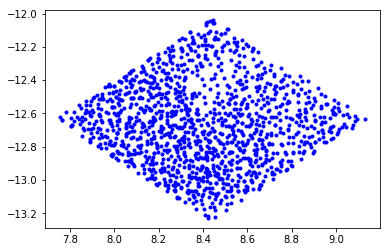

In [65]:
plt.plot(fm["RA_TARGET"],fm["DEC_TARGET"],'b.')

In [66]:
DM


  file: /Users/dummy/desi/spectro/redux/dc17a2/spectra-64/168/16879/spectra-64-16879.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       B_WAVELENGTH
  3      IMAGE_HDU       B_FLUX
  4      IMAGE_HDU       B_IVAR
  5      IMAGE_HDU       B_MASK
  6      IMAGE_HDU       B_RESOLUTION
  7      IMAGE_HDU       R_WAVELENGTH
  8      IMAGE_HDU       R_FLUX
  9      IMAGE_HDU       R_IVAR
  10     IMAGE_HDU       R_MASK
  11     IMAGE_HDU       R_RESOLUTION
  12     IMAGE_HDU       Z_WAVELENGTH
  13     IMAGE_HDU       Z_FLUX
  14     IMAGE_HDU       Z_IVAR
  15     IMAGE_HDU       Z_MASK
  16     IMAGE_HDU       Z_RESOLUTION

The remaining extensions store the wavelength, flux, inverse variance on the flux, mask and resolution matrix for the B, R and Z arms of the spectrograph. Let's determine the wavelength coverage of each spectrograph:

In [67]:
bwave = fitsio.read(specfilename,2)
rwave = fitsio.read(specfilename,7)
zwave = fitsio.read(specfilename,12)
print("B coverage: {:.1f} to {:.1f} Angstroms".format(np.min(bwave),np.max(bwave)))
print("R coverage: {:.1f} to {:.1f} Angstroms".format(np.min(rwave),np.max(rwave)))
print("Z coverage: {:.1f} to {:.1f} Angstroms".format(np.min(zwave),np.max(zwave)))

B coverage: 3569.4 to 5948.4 Angstroms
R coverage: 5625.4 to 7740.4 Angstroms
Z coverage: 7435.4 to 9833.4 Angstroms


## Reading in and Displaying spectra

Now that we understand the Data Model, let's plot some spectra. To start, let's use the file we've already been manipulating and read in the flux to go with the wavelengths we already have.

In [68]:
wave = np.hstack([bwave,rwave,zwave])

In [69]:
bflux = fitsio.read(specfilename,3)
rflux = fitsio.read(specfilename,8)
zflux = fitsio.read(specfilename,13)
flux = np.hstack([bflux,rflux,zflux])

Note that the wavelength arrays are 1-D (every spectrum in the spectral file is mapped to the same binning in wavelength) but the flux array (and flux_ivar, mask etc. arrays) are 2-D, because they contain multiple spectra:

In [70]:
print(wave.shape)
print(flux.shape)

(6895,)
(1339, 6895)


Let's plot the zeroth spectrum in this file (i.e. in this HEALPix grouping):

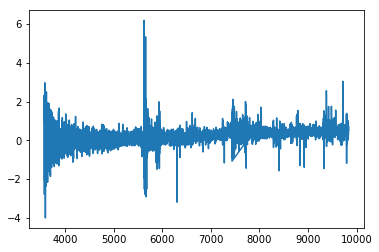

In [71]:
spectrum = 0
plt.plot(wave,flux[spectrum])

Let's plot it again, but color-coding for the arms of the spectrograph:

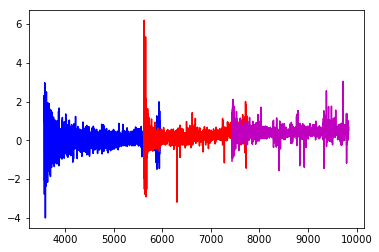

In [72]:
plt.plot(bwave,bflux[spectrum],color='b')
plt.plot(rwave,rflux[spectrum],color='r')
plt.plot(zwave,zflux[spectrum],color='m')

## Target classes

What about if we only want to plot spectra of certain target classes? The targeting information is stored in the `DESI_TARGET`, `BGS_TARGET` and `MWS_TARGET` entries of the fibermap array:

In [73]:
fm.dtype.descr

[('OBJTYPE', '|S10'),
 ('TARGETCAT', '|S20'),
 ('BRICKNAME', '|S8'),
 ('TARGETID', '>i8'),
 ('DESI_TARGET', '>i8'),
 ('BGS_TARGET', '>i8'),
 ('MWS_TARGET', '>i8'),
 ('MAG', '>f4', (5,)),
 ('FILTER', '|S10', (5,)),
 ('SPECTROID', '>i4'),
 ('POSITIONER', '>i4'),
 ('LOCATION', '>i4'),
 ('DEVICE_LOC', '>i4'),
 ('PETAL_LOC', '>i4'),
 ('FIBER', '>i4'),
 ('LAMBDAREF', '>f4'),
 ('RA_TARGET', '>f8'),
 ('DEC_TARGET', '>f8'),
 ('RA_OBS', '>f8'),
 ('DEC_OBS', '>f8'),
 ('X_TARGET', '>f8'),
 ('Y_TARGET', '>f8'),
 ('X_FVCOBS', '>f8'),
 ('Y_FVCOBS', '>f8'),
 ('Y_FVCERR', '>f4'),
 ('X_FVCERR', '>f4'),
 ('NIGHT', '>i4'),
 ('EXPID', '>i4')]

and which target corresponds to which targeting bit is stored in the desitarget mask (we imported this near the beginning of the notebook.

In [74]:
desi_mask

desi_mask:
  - [LRG,              0, "LRG", {'priorities': {'DONE': 2, 'MORE_ZWARN': 3200, 'OBS': 1, 'MORE_ZGOOD': 3200, 'DONOTOBSERVE': 0, 'UNOBS': 3200}, 'obsconditions': 'DARK'}]
  - [ELG,              1, "ELG", {'priorities': {'DONE': 2, 'MORE_ZWARN': 3000, 'OBS': 1, 'MORE_ZGOOD': 3000, 'DONOTOBSERVE': 0, 'UNOBS': 3000}, 'obsconditions': 'DARK|GRAY'}]
  - [QSO,              2, "QSO", {'priorities': {'DONE': 2, 'MORE_ZWARN': 3400, 'OBS': 1, 'MORE_ZGOOD': 3500, 'DONOTOBSERVE': 0, 'UNOBS': 3400}, 'obsconditions': 'DARK'}]
  - [LRG_NORTH,        8, "LRG from Bok/Mosaic data", {'priorities': {'DONE': 2, 'MORE_ZWARN': 3200, 'OBS': 1, 'MORE_ZGOOD': 3200, 'DONOTOBSERVE': 0, 'UNOBS': 3200}, 'obsconditions': 'DARK'}]
  - [ELG_NORTH,        9, "ELG from Bok/Mosaic data", {'priorities': {'DONE': 2, 'MORE_ZWARN': 3000, 'OBS': 1, 'MORE_ZGOOD': 3000, 'DONOTOBSERVE': 0, 'UNOBS': 3000}, 'obsconditions': 'DARK|GRAY'}]
  - [QSO_NORTH,       10, "QSO from Bok/Mosaic data", {'priorities': {'DONE': 2, '

Let's find the indexes of all standard F-stars in the spectral file:

In [75]:
stds = np.where(fm["DESI_TARGET"] & desi_mask["STD_FSTAR"])[0]
print(stds)

[ 289  413  533  589  686  702  848 1049 1126 1181]


Where were these located on the original plate-fiber mapping?

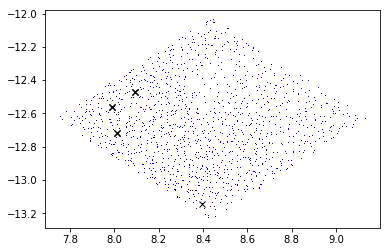

In [76]:
plt.plot(fm["RA_TARGET"],fm["DEC_TARGET"],'b,')
plt.plot(fm["RA_TARGET"][stds],fm["DEC_TARGET"][stds],'kx')

It should seem strange that there are 10 standard stars, but only 4 crosses in the plot. This is because we've uncovered one of the small bugs in the current runs of the Data Challenge. TARGETID is meant to be unique, but some standard stars have duplicate TARGETIDs, e.g.:

In [77]:
zipper = zip(stds,fm["TARGETID"][stds],fm["RA_TARGET"][stds],fm["DEC_TARGET"][stds])
[print("INDEX: {} TARGETID: {} RA: {} DEC: {}".format(i,tid,ra,dec)) for i,tid,ra,dec in zipper]

INDEX: 289 TARGETID: 5190613424285644324 RA: 8.01411247253418 DEC: -12.717392921447754
INDEX: 413 TARGETID: 4175555081061669163 RA: 8.394190788269043 DEC: -13.142195701599121
INDEX: 533 TARGETID: 3867431311113319136 RA: 8.09453296661377 DEC: -12.469233512878418
INDEX: 589 TARGETID: 5602376427145071993 RA: 7.988302707672119 DEC: -12.56336784362793
INDEX: 686 TARGETID: 5190613424285644324 RA: 8.01411247253418 DEC: -12.717392921447754
INDEX: 702 TARGETID: 5602376427145071993 RA: 7.988302707672119 DEC: -12.56336784362793
INDEX: 848 TARGETID: 3867431311113319136 RA: 8.09453296661377 DEC: -12.469233512878418
INDEX: 1049 TARGETID: 3867431311113319136 RA: 8.09453296661377 DEC: -12.469233512878418
INDEX: 1126 TARGETID: 5602376427145071993 RA: 7.988302707672119 DEC: -12.56336784362793
INDEX: 1181 TARGETID: 5190613424285644324 RA: 8.01411247253418 DEC: -12.717392921447754


[None, None, None, None, None, None, None, None, None, None]

This will not be the case for the real survey (or for subsequent iterations of the Data Challenge)!

Let's take a look at the spectra of these standard stars:

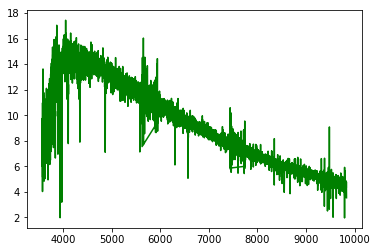

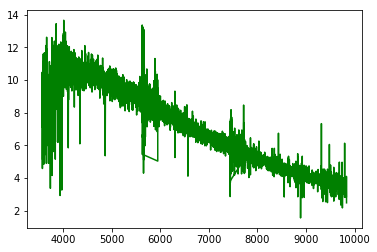

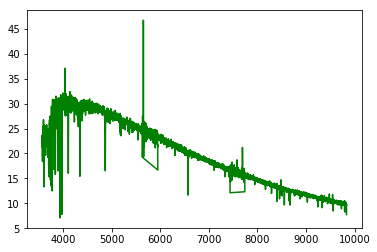

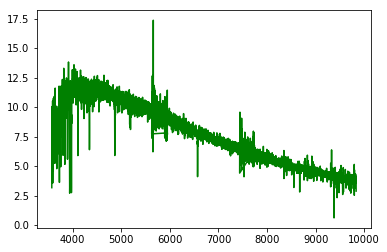

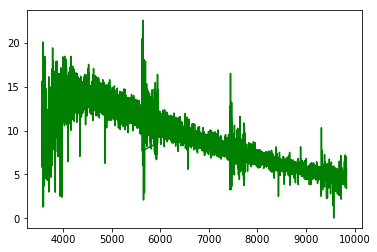

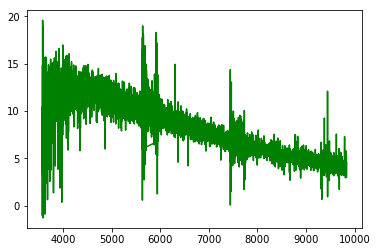

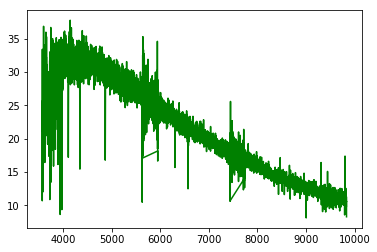

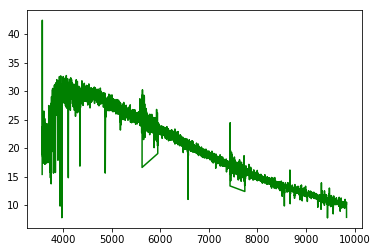

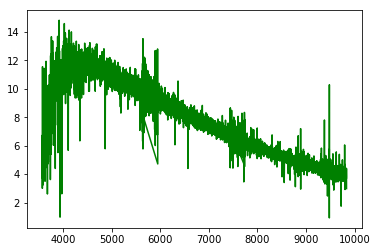

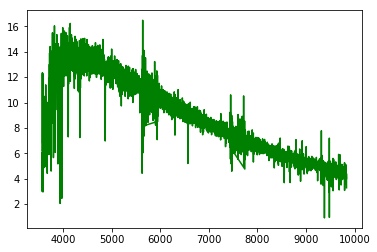

In [78]:
for i in range(len(stds)):
    plt.plot(wave,flux[stds[i]],'g')
    plt.show()

These seem realistic. Let's zoom in on some of the Balmer series for the zeroth standard:

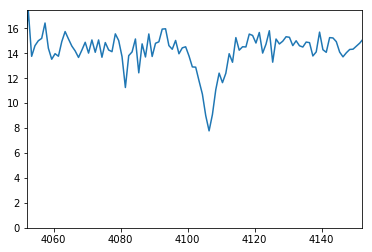

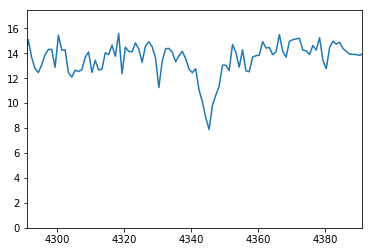

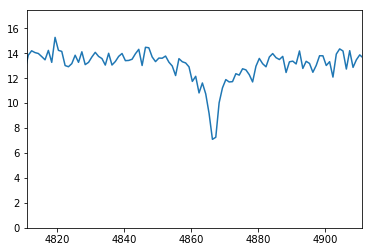

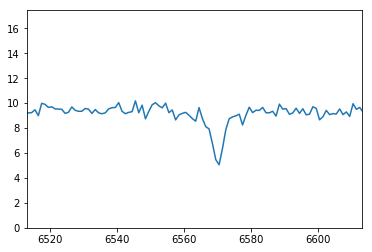

In [79]:
Balmer = [4102,4341,4861,6563]
halfwindow = 50
for i in range(len(Balmer)):
    plt.axis([Balmer[i]-halfwindow,Balmer[i]+halfwindow,0,np.max(flux[stds[0]])])
    plt.plot(wave,flux[stds[0]])
    plt.show()

## Redshifts

The directory from which we took these spectra, also contains information on the best-fit redshifts for the spectra from the [redrock](https://github.com/desihub/redrock) code. Let's read that file and examine its contents:

In [80]:
zfilename = glob(os.path.join(basedir,'zbest*fits'))[0]
zs = fitsio.read(zfilename)
zs.dtype.descr

[('CHI2', '>f8'),
 ('COEFF', '>f8', (10,)),
 ('Z', '>f8'),
 ('ZERR', '>f8'),
 ('ZWARN', '>i8'),
 ('SPECTYPE', '|S6'),
 ('SUBTYPE', '|S1'),
 ('TARGETID', '>i8'),
 ('DELTACHI2', '>f8'),
 ('BRICKNAME', '|S8')]

Note that there are a different number of entries in the redshift and spectral file, meaning that there isn't a row-by-row mapping between spectra and redshifts...

In [81]:
print(zs.shape)
print(bflux.shape)

(1275,)
(1339, 2380)


...but the `TARGETID` (which *is* intended to be unique) is in this file, too, allowing sources to be uniquely mapped from targeting, to spectra, to redshift. Let's extract all sources that were targeted as quasars using the fibermap information from the spectral file, and plot the first 20:

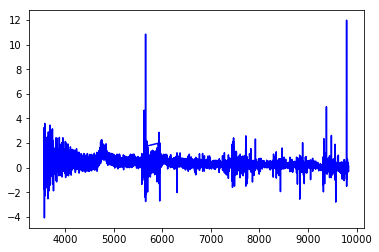

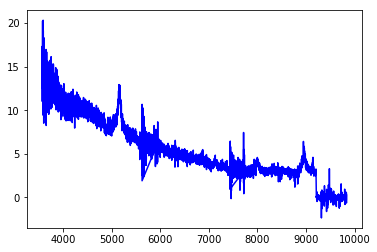

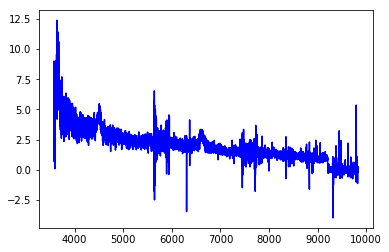

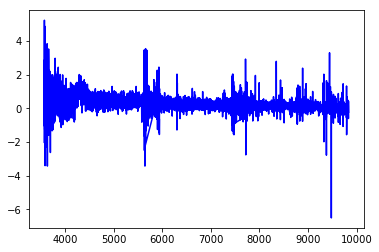

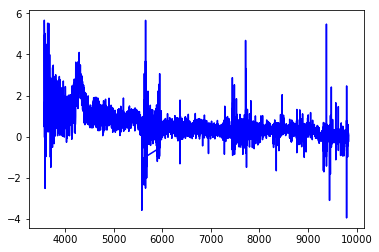

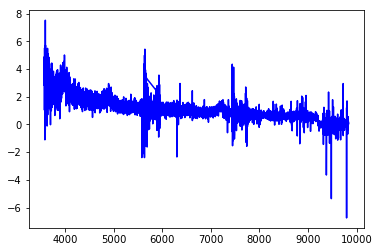

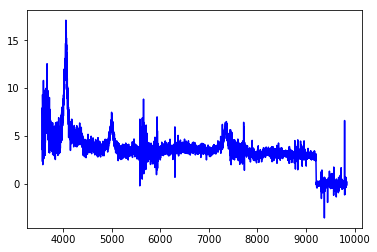

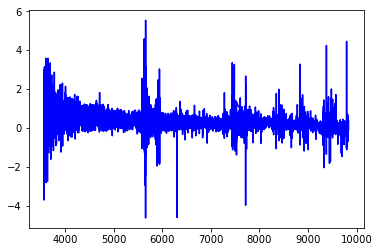

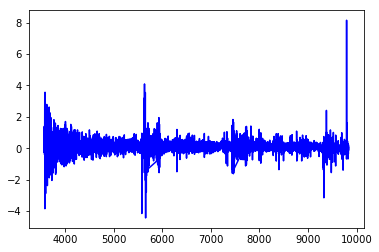

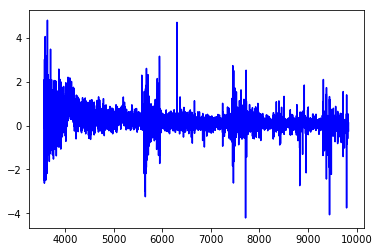

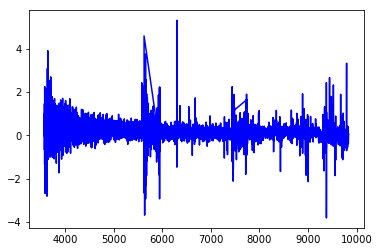

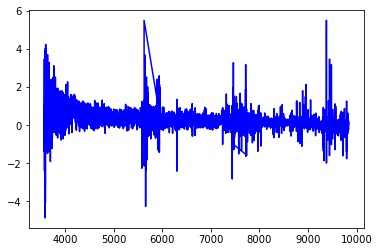

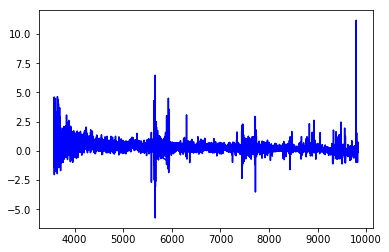

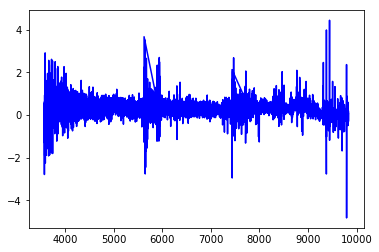

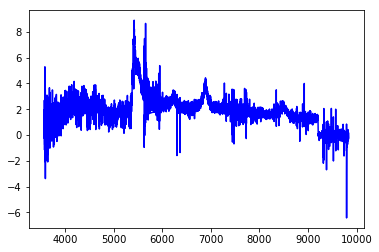

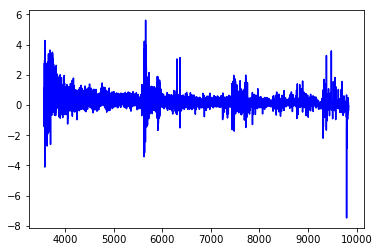

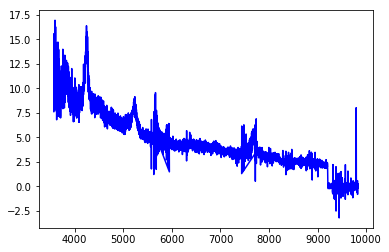

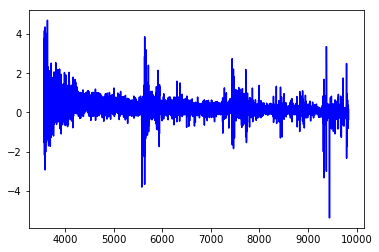

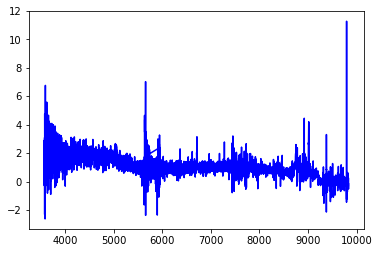

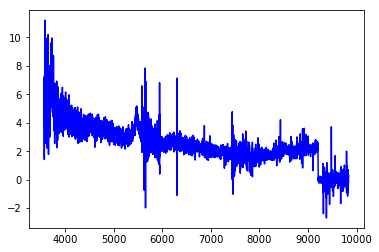

In [82]:
qsos = np.where(fm["DESI_TARGET"] & desi_mask["QSO"])[0]
for i in range(20):
    plt.plot(wave,flux[qsos[i]],'b')
    plt.show()

Let's match these quasar targets to the redshift file on `TARGETID` to extract their best-fit redshifts from `redrock`:

In [83]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zqsos = [index for item in fm[qsos]["TARGETID"] for index in dd[item] if item in dd]

That might be hard to follow at first glance, but all I did was use some "standard" python syntax to match the indices in `zs` (the ordering of objects in the `redrock` redshift file) to those for quasars in `fm` (the ordering of quasars in the fibermap file), on the unique `TARGETID`, such that the indices stored in `qsos` for `fm` point to the corresponding indices in `zqsos` for `zs`. This might help illustrate the result:

In [84]:
zs[zqsos]["TARGETID"][0:7], fm[qsos]["TARGETID"][0:7]

(array([6205855434767175128, 8658815612094195919, 8362360544984442534,
        2741684827213521854, 2504338256912405271, 2229181246596958769,
        3200382753559222849]),
 array([6205855434767175128, 8658815612094195919, 8362360544984442534,
        2741684827213521854, 2504338256912405271, 2229181246596958769,
        3200382753559222849]))

Let's see what best-fit template `redrock` assigned to each quasar. This information is stored in the `SPECTYPE` column.

In [85]:
zs[zqsos]["SPECTYPE"]

array([b'QSO   ', b'GALAXY', b'QSO   ', b'QSO   ', b'QSO   ', b'GALAXY',
       b'GALAXY', b'GALAXY', b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY',
       b'GALAXY', b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY', b'GALAXY',
       b'QSO   ', b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY', b'QSO   ',
       b'GALAXY', b'GALAXY', b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY',
       b'QSO   ', b'GALAXY', b'GALAXY', b'GALAXY', b'GALAXY', b'GALAXY',
       b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY', b'GALAXY', b'GALAXY',
       b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY', b'GALAXY', b'GALAXY',
       b'QSO   ', b'GALAXY', b'GALAXY', b'GALAXY', b'GALAXY', b'GALAXY',
       b'GALAXY', b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY', b'QSO   ',
       b'GALAXY', b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY', b'GALAXY',
       b'QSO   ', b'GALAXY', b'QSO   ', b'GALAXY', b'GALAXY', b'GALAXY',
       b'GALAXY', b'GALAXY', b'GALAXY', b'QSO   ', b'GALAXY', b'QSO   ',
       b'GALAXY', b'GALAXY', b'GALAXY', b'GALAXY', 

Here, we've (partially) encountered a second minor bug in the Data Challenge: `redrock` is currently not doing a fantastic job of fitting quasars. It correctly identified some, though. And, of course, not everything *targeted* as a quasar will turn out to actually *be* a quasar (there are some contaminants).

If we'd instead performed this same check for the standard stars, everything would have looked more reasonable:

In [86]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zstds = [index for item in fm[stds]["TARGETID"] for index in dd[item] if item in dd]

For stars, we can also display the type of star that `redrock` fit (this is stored in the `SUBTYPE` column):

In [87]:
zipper = zip(zs[zstds]["SUBTYPE"],zs[zstds]["SPECTYPE"])
[ print("{}-{}".format(sub.decode('utf-8'),spec.decode('utf-8'))) for sub,spec in zipper ]

G-STAR  
G-STAR  
G-STAR  
G-STAR  
G-STAR  
G-STAR  
G-STAR  
G-STAR  
G-STAR  
G-STAR  


[None, None, None, None, None, None, None, None, None, None]

(here the conversion to `utf-8` is simply for display purposes because the strings in `SUBTYPE` and `SPECTYPE` are stored as bytes instead of unicode).

OK, back to our quasars. Let's plot the quasar targets that *are identified as quasars* , but add a label for the `SPECTYPE` and the redshift fit by `redrock`. I'll also over-plot some (approximate) typical quasar emission lines at the redrock redshift (if those lines would fall in the DESI wavelength coverage):

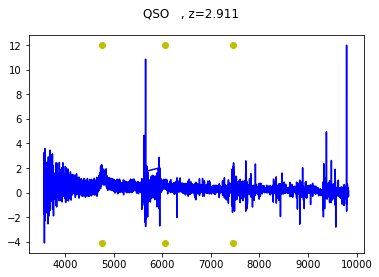

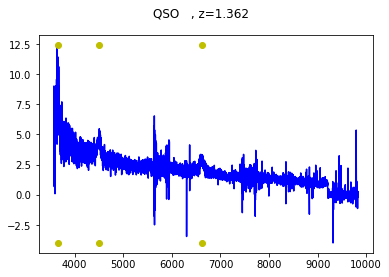

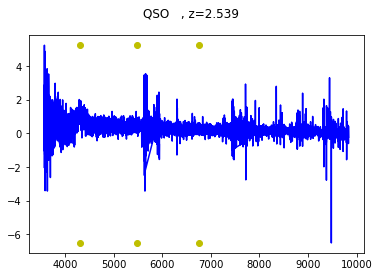

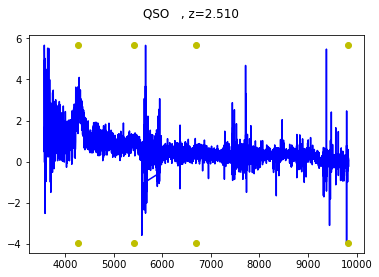

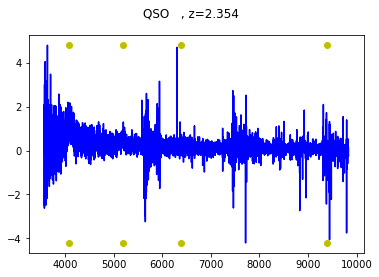

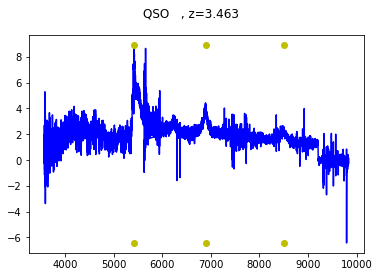

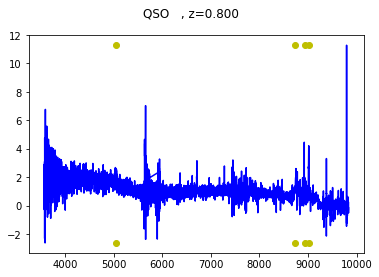

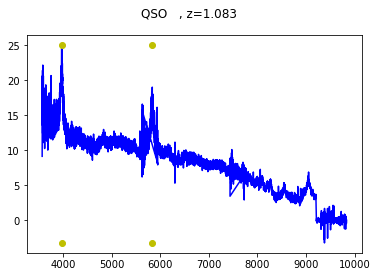

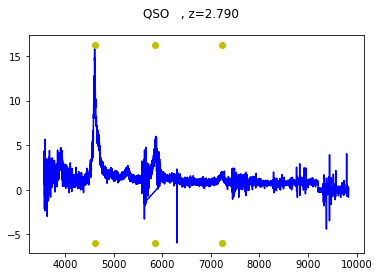

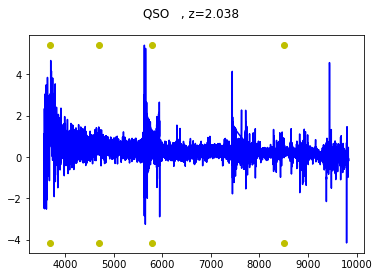

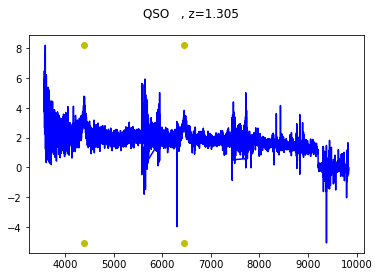

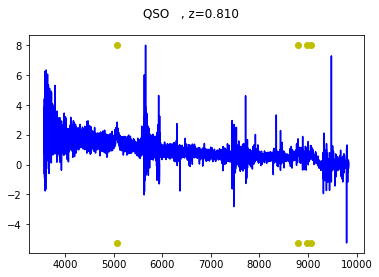

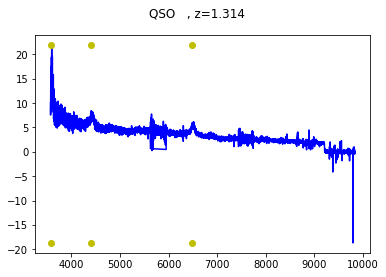

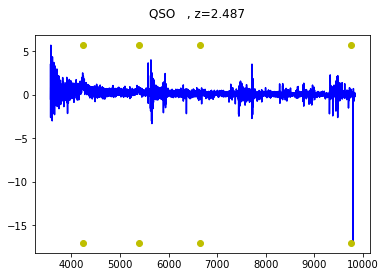

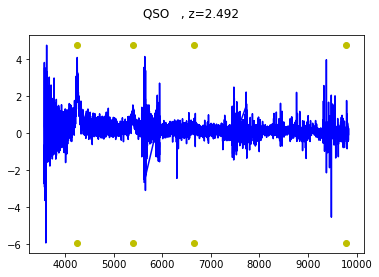

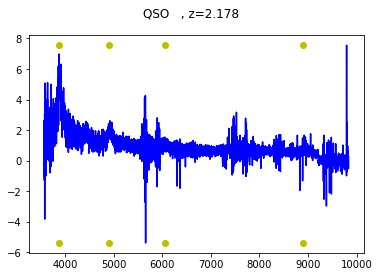

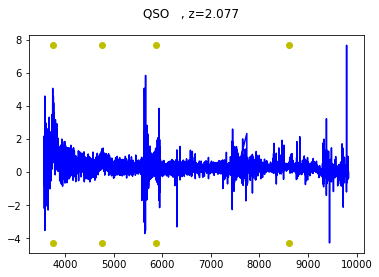

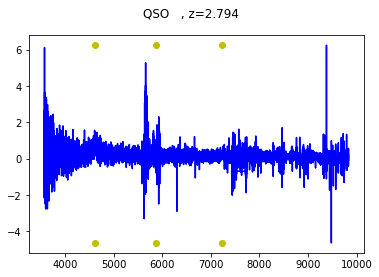

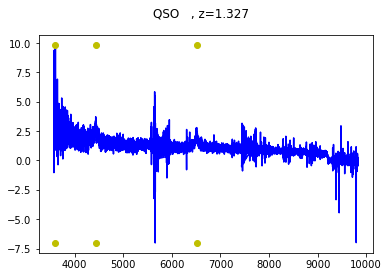

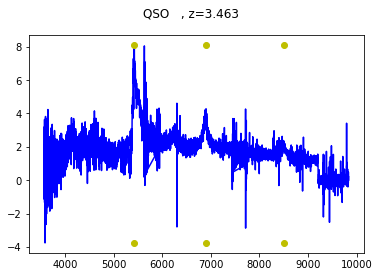

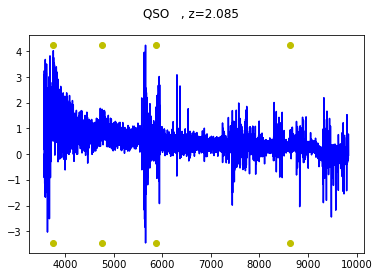

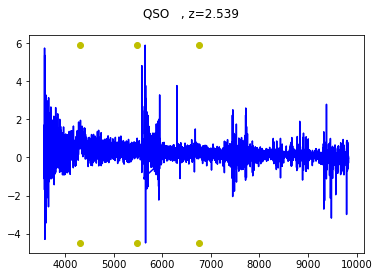

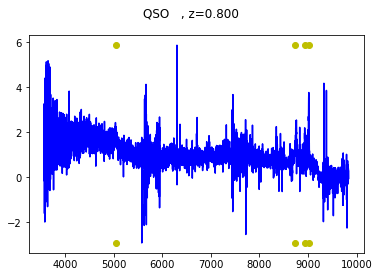

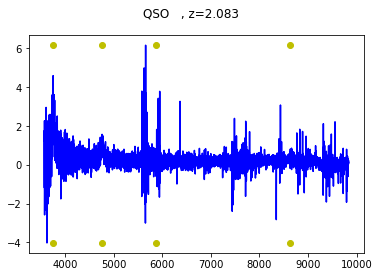

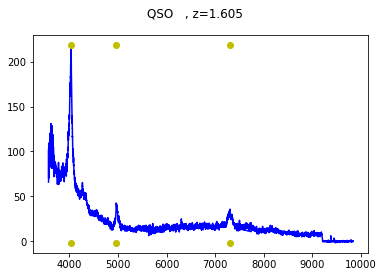

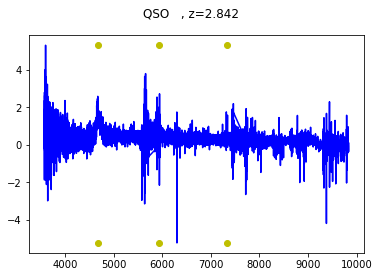

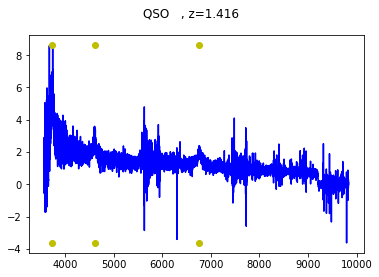

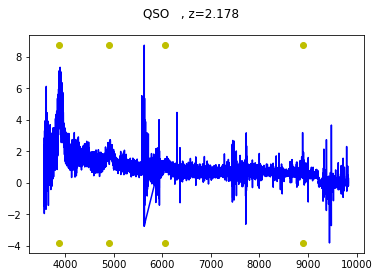

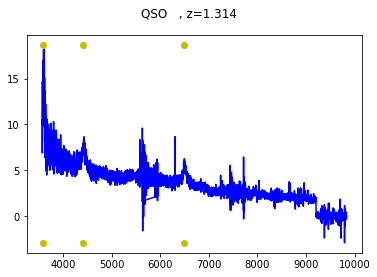

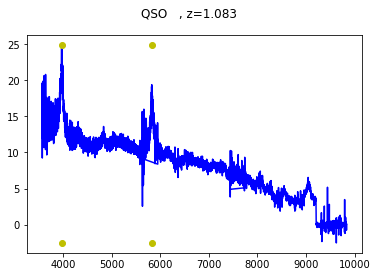

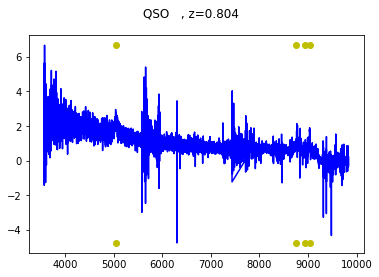

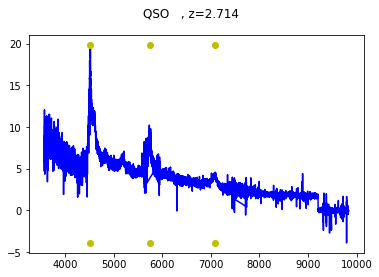

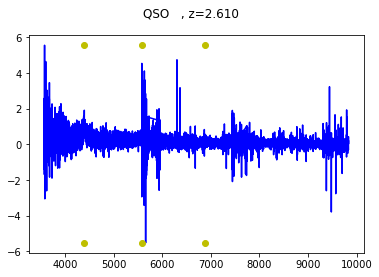

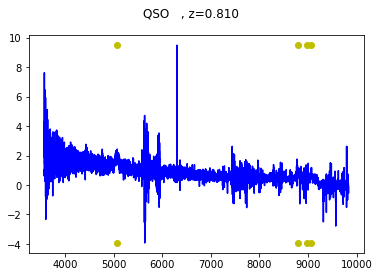

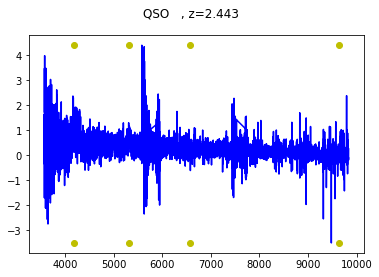

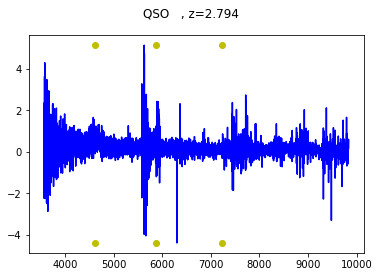

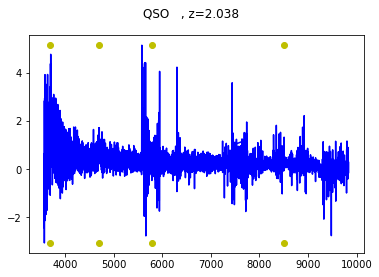

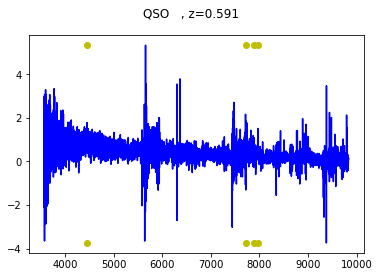

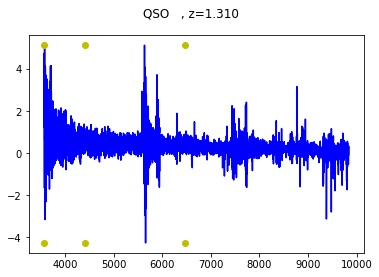

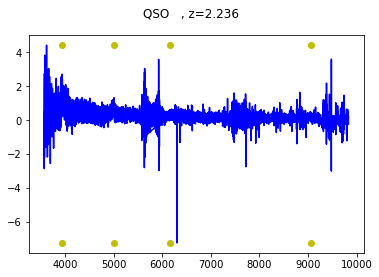

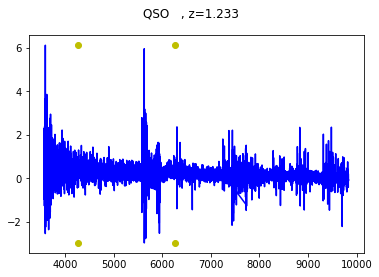

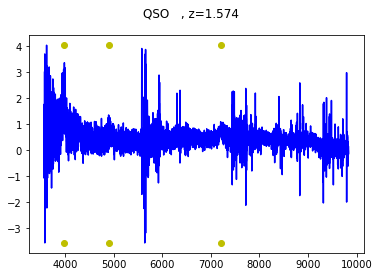

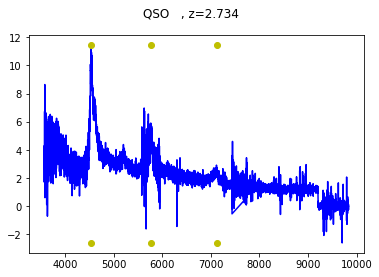

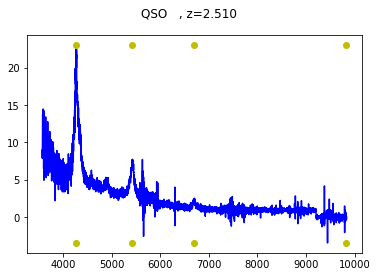

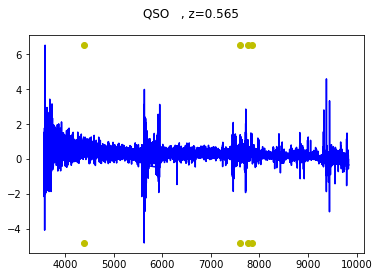

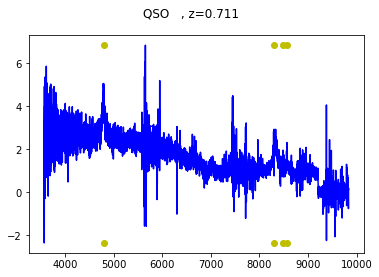

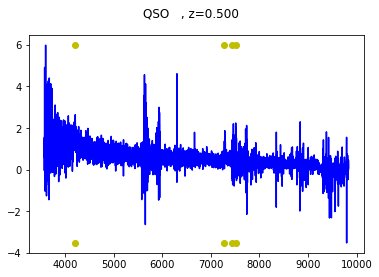

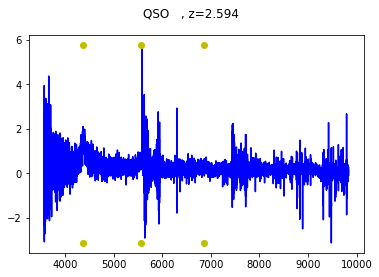

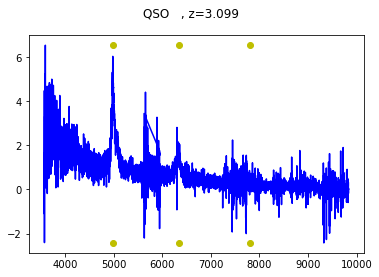

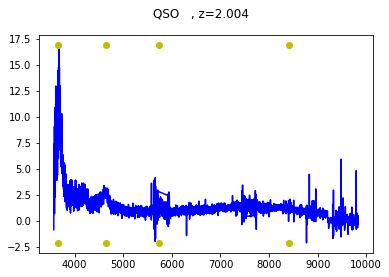

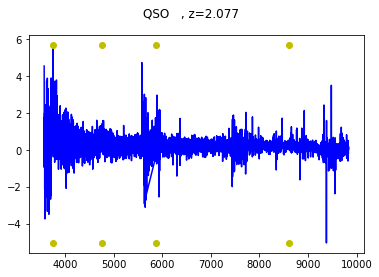

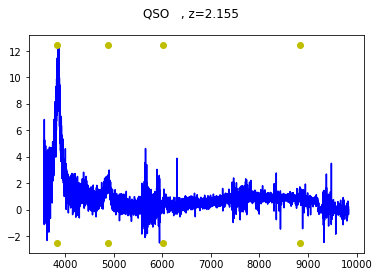

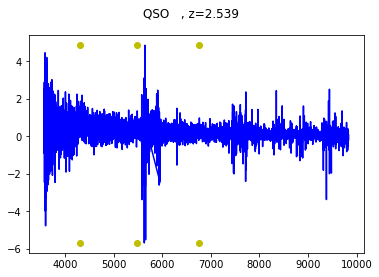

In [90]:
qsoid = np.where(zs[zqsos]["SPECTYPE"] == b'QSO   ')[0]
qsolines = np.array([1216,1546,1906,2800,4853,4960,5008])
for i in range(len(qsoid)):
    spectype = zs[zqsos[qsoid[i]]]["SPECTYPE"].decode('utf-8')
    z = zs[zqsos[qsoid[i]]]["Z"]
    plt.plot(wave,flux[qsos[qsoid[i]]],'b')
    plt.suptitle("{}, z={:.3f}".format(spectype,z))
    for line in qsolines:
        if ((1+z)*line > np.min(wave)) & ((1+z)*line < np.max(wave)):
            plt.plot([(1+z)*line,(1+z)*line],[np.min(flux[qsos[qsoid[i]]]),np.max(flux[qsos[qsoid[i]]])],'yo')
    plt.show()

Not bad at all!

## A DESI-specific spectrum reader

Note that, for illustrative purposes, we discussed the Data Model in detail and read in the required files individually from that Data Model. But, the DESI data team has also developed standalone functions in `desispec.io` to facilitate reading in the plethora of information in the spectral files. For example:

In [91]:
from desispec import io

In [92]:
specobj = io.read_spectra(specfilename)

The wavelengths and flux in each band are then available as dictionaries in the `wave` and `flux` attributes:

In [93]:
specobj.wave

{'b': array([ 3569.39990234,  3570.39990234,  3571.39990234, ...,  5946.39990234,
         5947.39990234,  5948.39990234]),
 'r': array([ 5625.39990234,  5626.39990234,  5627.39990234, ...,  7738.39990234,
         7739.39990234,  7740.39990234]),
 'z': array([ 7435.39990234,  7436.39990234,  7437.39990234, ...,  9831.40039062,
         9832.40039062,  9833.40039062])}

In [94]:
specobj.flux

{'b': array([[ 1.29933512,  1.0022347 ,  2.32936954, ...,  1.5098393 ,
         -0.31815678, -0.68129355],
        [ 0.16481797,  2.58091903,  4.13131285, ...,  2.17221141,
         -0.15947284, -0.80120361],
        [-0.54065394,  0.97795463,  1.86999583, ...,  0.65832251,
          1.00964594, -1.06500113],
        ..., 
        [-0.74732822,  0.10489039,  1.5838306 , ..., -0.87190139,
         -1.05336905,  0.42119172],
        [-0.93642825, -1.43342793, -0.26964673, ..., -1.01840055,
          0.20170136,  1.01352084],
        [-1.39619613,  3.12872791, -1.46959674, ..., -1.49910605,
         -0.30297413, -0.25393745]]),
 'r': array([[ 0.28202024, -1.96098185,  6.19691467, ...,  1.26411927,
          0.93296349, -0.02513243],
        [-2.86186576, -2.00580311, -1.7183876 , ..., -0.51273662,
         -0.44679055,  0.93515539],
        [-1.1710645 , -1.11826515, -0.66710347, ..., -0.01358135,
         -0.70192206,  1.62991178],
        ..., 
        [ 0.13366452,  0.77143681, -0.9709

So, to plot the "zeroth" spectrum:

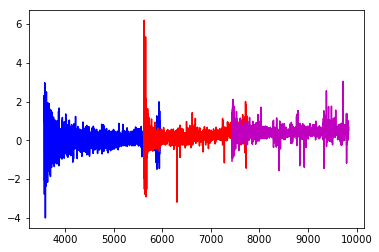

In [95]:
spectrum = 0
plt.plot(specobj.wave["b"],specobj.flux["b"][spectrum],color='b')
plt.plot(specobj.wave["r"],specobj.flux["r"][spectrum],color='r')
plt.plot(specobj.wave["z"],specobj.flux["z"][spectrum],color='m')

which should look very similar to one of the first plots we made earlier in the tutorial. 

The fibermap information is available as a table in the `fibermap` attribute:

In [99]:
specobj.fmap

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR,NIGHT,EXPID
bytes10,bytes20,bytes8,int64,int64,int64,int64,float32,bytes10,int32,int32,int32,int32,int32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,int32
SCIENCE,,0090m125,6507767938450030088,65537,0,0,24.1158 .. 19.6316,DECAM_G .. WISE_W2,1,1274,1274,274,1,648,5400.0,9.04720687866,-12.5566692352,9.04720687866,-12.5566692352,226.204589844,-171.835830688,226.204589844,-171.835830688,0.0,0.0,20190829,17
SCIENCE,,0088m125,7131316775476678757,65537,0,0,24.2044 .. 18.7743,DECAM_G .. WISE_W2,1,1415,1415,415,1,866,5400.0,8.84630966187,-12.4065351486,8.84630966187,-12.4065351486,277.986328125,-211.142669678,277.986328125,-211.142669678,0.0,0.0,20190829,17
SCIENCE,,0088m125,6804217574472183230,131074,0,0,22.7718 .. 21.7344,DECAM_G .. WISE_W2,1,1372,1372,372,1,894,5400.0,8.91900730133,-12.450094223,8.91900730133,-12.450094223,259.144012451,-199.534393311,259.144012451,-199.534393311,0.0,0.0,20190829,17
SCIENCE,,0085m130,1544007044481327018,131074,0,0,21.2209 .. 21.3602,DECAM_G .. WISE_W2,2,2412,2412,412,2,1064,5400.0,8.59010314941,-13.0708370209,8.59010314941,-13.0708370209,339.509246826,-43.9885101318,339.509246826,-43.9885101318,0.0,0.0,20190829,17
SCIENCE,,0085m130,7392022591630237649,65537,0,0,23.7062 .. 19.4215,DECAM_G .. WISE_W2,2,2389,2389,389,2,1068,5400.0,8.62276554108,-13.0125303268,8.62276554108,-13.0125303268,331.274200439,-58.5953559875,331.274200439,-58.5953559875,0.0,0.0,20190829,17
SCIENCE,,0085m130,1028179647407169089,65537,0,0,24.0897 .. 18.8311,DECAM_G .. WISE_W2,2,2390,2390,390,2,1070,5400.0,8.62519454956,-13.0554590225,8.62519454956,-13.0554590225,330.484649658,-47.8234100342,330.484649658,-47.8234100342,0.0,0.0,20190829,17
SCIENCE,,0085m130,6659686054943832193,131074,0,0,23.7502 .. 21.2074,DECAM_G .. WISE_W2,2,2368,2368,368,2,1079,5400.0,8.65417861938,-13.0452861786,8.65417861938,-13.0452861786,323.051086426,-50.3499641418,323.051086426,-50.3499641418,0.0,0.0,20190829,17
SCIENCE,,0085m127,211424242957042065,65537,0,0,23.6676 .. 18.9103,DECAM_G .. WISE_W2,2,2467,2467,467,2,1100,5400.0,8.55505943298,-12.6491594315,8.55505943298,-12.6491594315,351.152862549,-150.762237549,351.152862549,-150.762237549,0.0,0.0,20190829,17
SCIENCE,,0085m127,2712030920558351662,65537,0,0,23.6736 .. 19.7311,DECAM_G .. WISE_W2,2,2489,2489,489,2,1101,5400.0,8.49149131775,-12.7854223251,8.49149131775,-12.7854223251,366.7996521,-116.31211853,366.7996521,-116.31211853,0.0,0.0,20190829,17


and the `TARGETID` for each source is available via its own method:

In [100]:
specobj.target_ids()

6507767938450030088
7131316775476678757
6804217574472183230
1544007044481327018
7392022591630237649
1028179647407169089
6659686054943832193
211424242957042065
2712030920558351662
6260777520251217416
6205855434767175128


All of the information that could be read in from the different extensions of the spectral file can be retrieved from the `specobj` object. Here's what's available:

In [101]:
dir(specobj)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bands',
 '_ftype',
 '_single',
 'bands',
 'extra',
 'flux',
 'fmap',
 'ftype',
 'ivar',
 'mask',
 'meta',
 'num_spectra',
 'num_targets',
 'resolution_data',
 'select',
 'target_ids',
 'update',
 'wave',
 'wavelength_grid']